In [42]:
import os
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import jupyterthemes.jtplot
import matplotlib.pyplot as plt

In [18]:
#Set sns plotting style to override defaults, 
jupyterthemes.jtplot.style()
sns.set()

In [13]:
df_wine = pd.read_csv("/home/armaan/Desktop/projects/data/winemag-data_first150k.csv", index_col=0)

In [21]:
print(df_wine.shape)
print(df_wine.columns)

(150930, 10)
Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'variety', 'winery'],
      dtype='object')


In [84]:
df_wine.variety.value_counts().head()

Chardonnay                  14482
Pinot Noir                  14291
Cabernet Sauvignon          12800
Red Blend                   10062
Bordeaux-style Red Blend     7347
Name: variety, dtype: int64

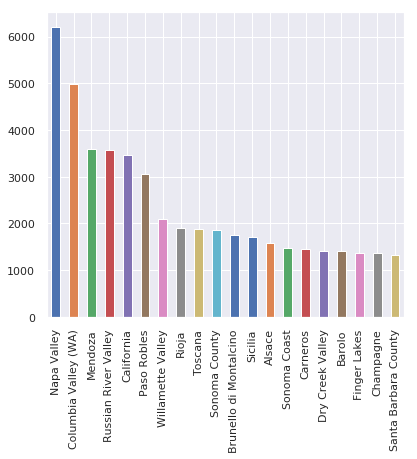

In [25]:
## Basic visualization
df_wine.region_1.value_counts().head(20).plot.bar()

hexbin is pretty good slternative for scatter plot, it aggregates based on gridsize and shows them as density

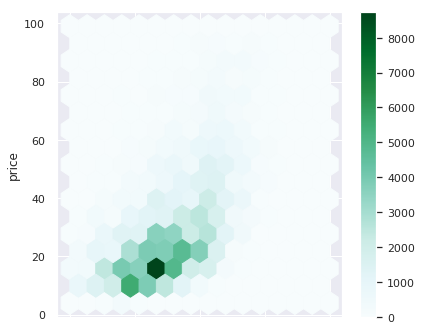

In [39]:
#Now let's try a country wise region split
df_wine[df_wine.price<100].plot.hexbin(x='points', y='price', gridsize=15)

Text(0.5,1,'Price distribution clipped at 200$ - KDE')

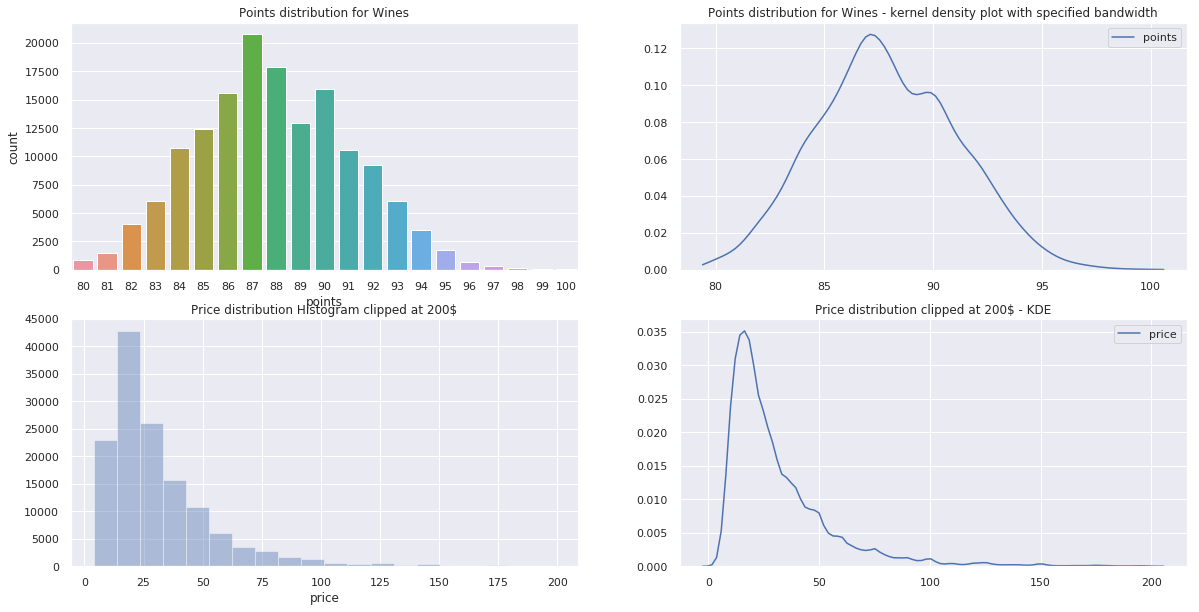

In [117]:
price_clip=200
fig, ax = plt.subplots(2,2,figsize=(20,10))
sns.countplot(df_wine.points, ax=ax[0][0])
ax[0,0].set_title("Points distribution for Wines")
sns.kdeplot(df_wine.points, ax=ax[0][1], bw=0.20)
ax[0,1].set_title("Points distribution for Wines - kernel density plot with specified bandwidth")
#Let's see if proce really has an effect on scores, break down into low and high price segment, what's the avg price?
sns.distplot(df_wine[df_wine.price<price_clip].price, ax=ax[1][0], bins=20, kde=False)
ax[1][0].set_title("Price distribution Histogram clipped at {}$".format(price_clip))
sns.kdeplot(df_wine[df_wine.price<price_clip].price, ax=ax[1][1])
ax[1][1].set_title("Price distribution clipped at {}$ - KDE".format(price_clip))

In [55]:
def get_price_range(price):
    if price>150: return "V.High"
    elif price>50: return "High"
    else: return "Avg"

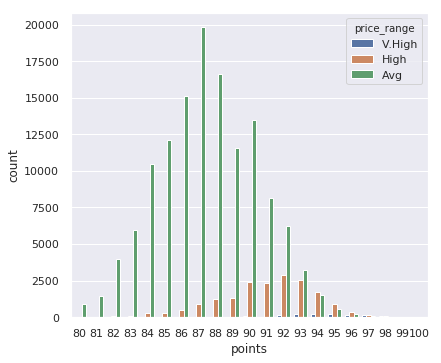

In [57]:
#From above, seems like 40-50 is a good cut off for high price wines, let's just split by 3 ranges
df_wine['price_range'] = df_wine.price.apply(lambda x: get_price_range(x))
sns.countplot(df_wine.points, hue=df_wine.price_range)
##From this plot, it is very clear that expensive wines have a certain edge in points, is this statistically significant? We need advanced mathematics to tackle that question with confidence!

Okay, moving on .. we can use the kernel density estimation plots in 2 dimensions as well, 

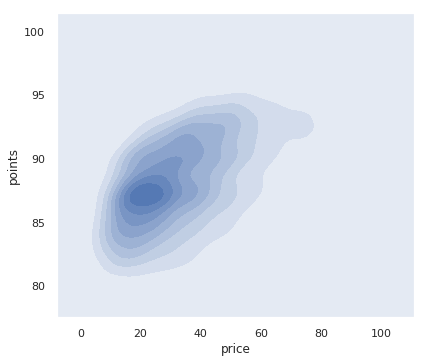

In [159]:
df_tmp = df_wine[df_wine.price<100].dropna().sample(5000)
sns.kdeplot(df_tmp['price'], df_tmp['points'], shade=True)

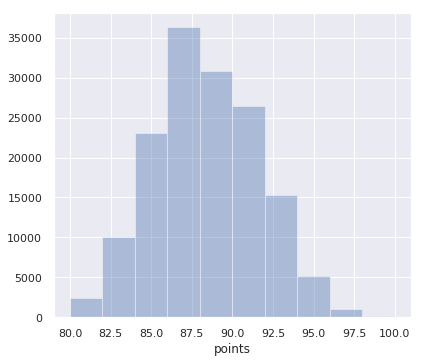

In [68]:
sns.distplot(df_wine.points, bins=10, kde=False)

/home/armaan/.local/share/virtualenvs/Desktop-9TTn8RCB/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


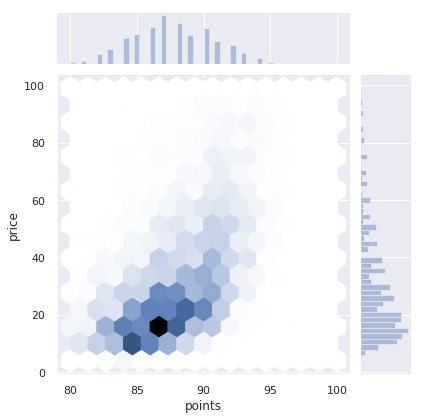

In [164]:
## A jointplot is a pretty good way to sum up relationship between 2 ordinal variables, you can customize the inner plot, this one with 
data=df_wine[df_wine.price<100]
sns.jointplot(data['points'], data['price'], kind='hex', gridsize=15)

/home/armaan/.local/share/virtualenvs/Desktop-9TTn8RCB/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


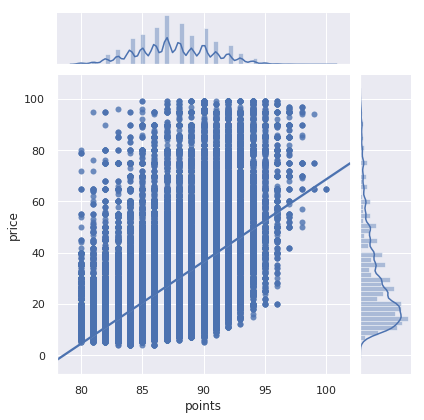

In [81]:
## The same jointplot can be used to answer a simple regression question of the relation between variables
sns.jointplot('points', 'price', data=df_wine[df_wine.price<100], kind='reg')
## We see that the relationship is solidly positive

/home/armaan/.local/share/virtualenvs/Desktop-9TTn8RCB/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


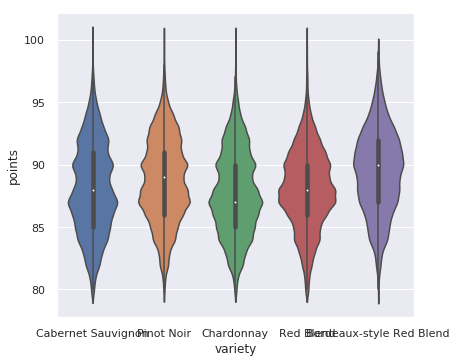

In [110]:
## Now let's look at some box plots and violin plots: These are used for categorical variables with nuerical properties
## Let's try to plot the top 5 wines by count and their rating spread
sns.violinplot(x='variety', y='points',data=df_wine[df_wine.variety.isin(df_wine.variety.value_counts().head(5).index)])

# Faceting data with seaborn
### Until now we can explore only one side of the data with univariate and bivariate plots, now we'll see how to harness the power of faceting 

In [ ]:
#First let's assign a column and select data frame for the major 5 kinds of wine 

In [133]:
df = df_wine[df_wine.variety.isin(df_wine.variety.value_counts().head(3).index)]

In [134]:
df.variety.value_counts()
df.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'variety', 'winery', 'price_range'],
      dtype='object')

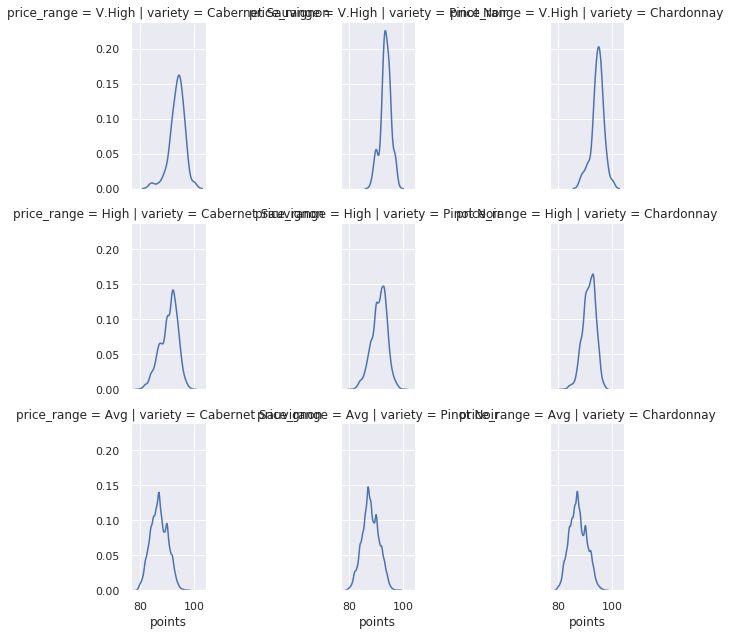

In [135]:
#Now let's construct the facets 
#col_wrap is required to breakup up display plots, make 
fg = sns.FacetGrid(df, col='variety',row="price_range")
fg.map(sns.kdeplot, 'points')

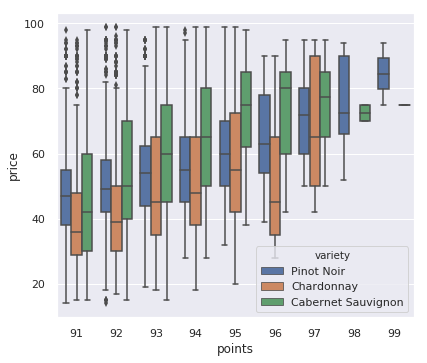

In [143]:
# Now let's do a multivariable plot
sns.boxplot(x='points', y='price', hue='variety', data=df[(df.price<100) & (df.points>90)])
#from here we conclude that for same points, Cabernet Sauvignon tends to be more expensive than Pinot Noir than Chardonnay

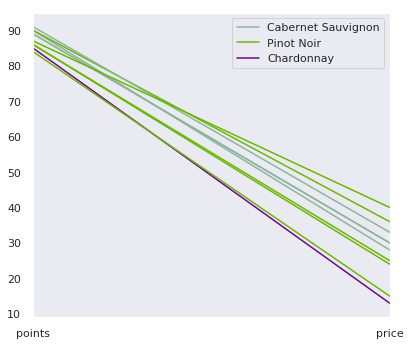

In [152]:
## Now let's do another plot, this time to see if we can discern wine variety from the points and price, it seems to me we can't but what's the harm in trying?
## So, let's go for a parallel coordinates plot
from pandas.plotting import parallel_coordinates
#First contruct a mini dataframe in right format
df_tmp = (df[['points', 'price']]
          .applymap(lambda v: v if v<100 else None)
          .dropna()
         )
df_tmp['variety'] = df.variety
parallel_coordinates(df_tmp.sample(10), 'variety')